# Problem No:4

In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [2]:
# load the data from CSV file
x_train = pd.read_csv("input_train.csv")
x_train = np.array(x_train.iloc[:,0:9])
y_train = pd.read_csv("output_train.csv")
y_train = np.array(y_train)

x_test = pd.read_csv("input_test.csv")
x_test = np.array(x_test.iloc[:,0:9])
y_test = pd.read_csv("output_test.csv")
y_test = np.array(y_test)

In [3]:
x_train

array([[1.0000e+00, 5.0788e-01, 6.6583e-01, ..., 0.0000e+00, 9.8214e-01,
        9.6701e-01],
       [2.0000e+00, 5.3655e-01, 5.4175e-01, ..., 0.0000e+00, 9.8203e-01,
        9.6071e-01],
       [3.0000e+00, 5.4527e-01, 5.5425e-01, ..., 0.0000e+00, 9.8204e-01,
        9.5395e-01],
       ...,
       [8.3200e+02, 3.2798e-01, 6.0939e-01, ..., 5.0000e-01, 9.6860e-01,
        9.8665e-01],
       [8.3300e+02, 3.5233e-01, 4.7526e-01, ..., 5.0000e-01, 9.7254e-01,
        9.8569e-01],
       [8.3400e+02, 3.6856e-01, 4.9240e-01, ..., 5.0000e-01, 9.7611e-01,
        9.8326e-01]])

In [4]:
print("y train shape:",y_train.shape)
print("x train shape:", x_train.shape)

y train shape: (3226, 3)
x train shape: (3226, 9)


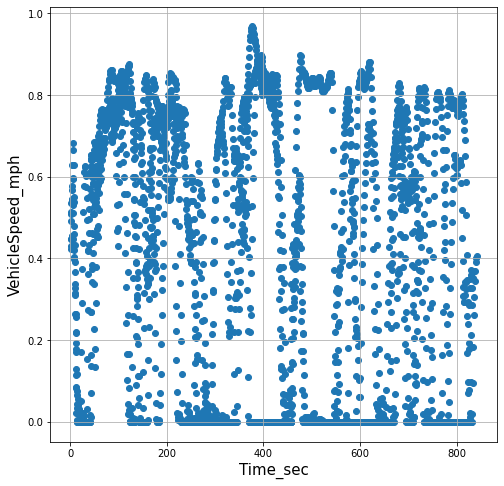

In [5]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x_train[0:,0],x_train[0:,1])
plt.xlabel('Time_sec', fontsize=15)
plt.ylabel('VehicleSpeed_mph', fontsize=15)
plt.grid()

# Random Forest

In [6]:
#prepare the model

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
#create an array which will hold samples split to be tested
samples_split = np.array([25, 50, 75, 100, 125, 150, 200, 250, 300, 500])
#create an empty array to hold Mean Abosulte error values
train_MAE = []
test_MAE = []
# For loop to go over different sample split scenarios
for i in range (0,10):
    regressor = RandomForestRegressor(n_estimators = 10, min_samples_split=samples_split[i],random_state = 2)
    regressor.fit(x_train, y_train)
    Predict = regressor.predict(x_train)
    Predict_test = regressor.predict(x_test)
    train_MAE.append(metrics.mean_absolute_error(y_train[:,0], Predict[:,0]))
    test_MAE.append(metrics.mean_absolute_error(y_test[:,0], Predict_test[:,0]))
    #print("Mean Absolute Error:", metrics.mean_absolute_error(y_train[:,0], Predict[:,0]))

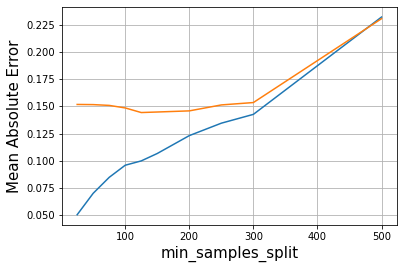

In [7]:
#Comapre the performance of training random forest model for training data set and test data set for predicting velocity
plt.figure(1)
plt.plot(samples_split, train_MAE)
plt.plot(samples_split, test_MAE)
plt.xlabel('min_samples_split', fontsize = 15)
plt.ylabel('Mean Absolute Error', fontsize = 15)
plt.grid()

In [8]:
# From above figure we can see that we get minimum test MAE score around 125.
finetuned_regressor = RandomForestRegressor( n_estimators = 10, min_samples_split=125,random_state = 2)
finetuned_regressor.fit(x_train, y_train)
finetuned_predict= finetuned_regressor.predict(x_train)
finetuned_predict_test = finetuned_regressor.predict(x_test)
print("Mean Absolute Error for training data set:", metrics.mean_absolute_error(y_train[:,0], finetuned_predict[:,0]))
print("Mean Absolute Error for test data set:", metrics.mean_absolute_error(y_test[:,0], finetuned_predict_test[:,0]))

Mean Absolute Error for training data set: 0.09981087986540094
Mean Absolute Error for test data set: 0.1443185990833361


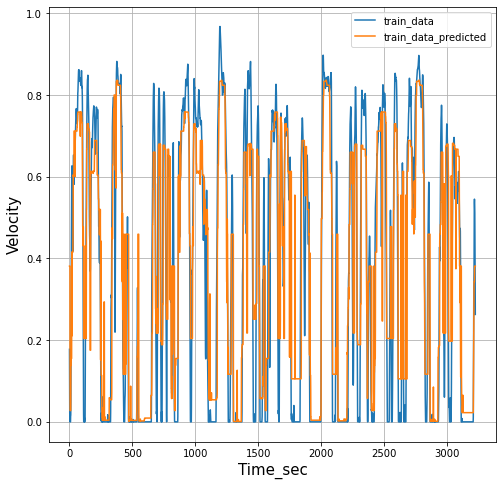

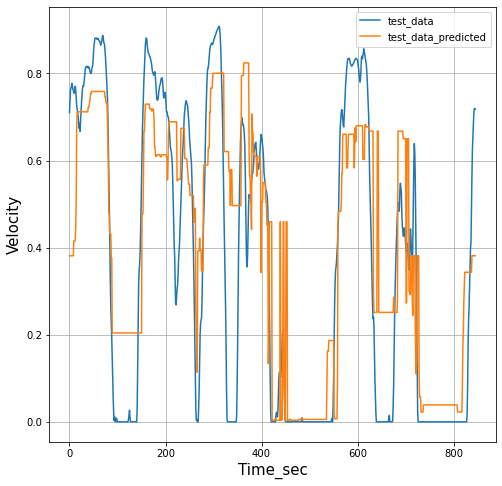

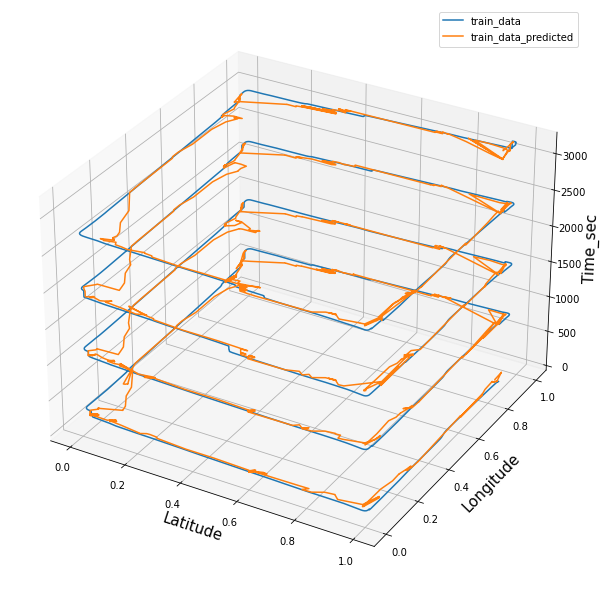

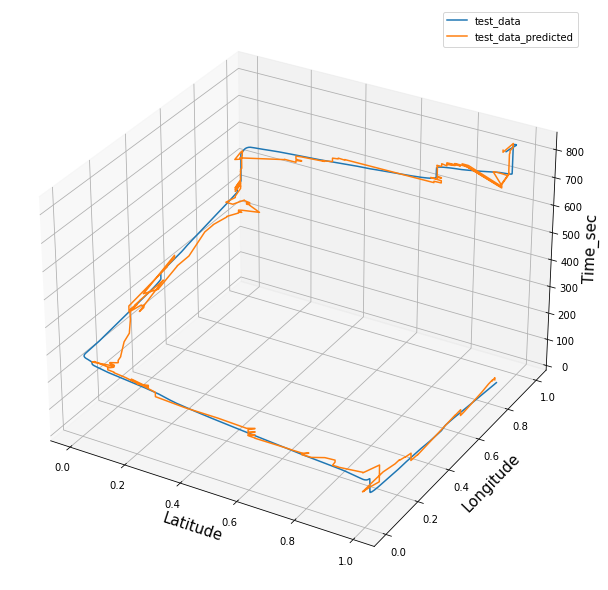

In [9]:
plt.figure(2, figsize=(8,8))
plt.plot(y_train[:,0], label="train_data")
plt.plot(finetuned_predict[:,0], label="train_data_predicted" )
plt.xlabel('Time_sec', fontsize = 15)
plt.ylabel('Velocity', fontsize = 15)
plt.legend()
plt.grid()

plt.figure(3, figsize=(8,8))
plt.plot(y_test[:,0], label="test_data")
plt.plot(finetuned_predict_test[:,0], label="test_data_predicted")
plt.xlabel('Time_sec', fontsize = 15)
plt.ylabel('Velocity', fontsize = 15)
plt.legend()
plt.grid()


fig = plt.figure(4, figsize=(8,8))
steps = list(range(0,3226))
ax = Axes3D(fig)
ax.plot3D(y_train[:,1],y_train[:,2], steps, label="train_data")
ax.plot3D(finetuned_predict[:,1], finetuned_predict[:,2], steps ,label="train_data_predicted")
ax.set_xlabel('Latitude', fontsize = 15)
ax.set_ylabel('Longitude', fontsize = 15)
ax.set_zlabel("Time_sec", fontsize = 15)
plt.legend()
plt.grid()


fig = plt.figure(5, figsize=(8,8))
steps = list(range(0,846))
ax = Axes3D(fig)
ax.plot3D(y_test[:,1],y_test[:,2], steps, label="test_data")
ax.plot3D(finetuned_predict_test[:,1], finetuned_predict_test[:,2], steps ,label="test_data_predicted")
ax.set_xlabel('Latitude', fontsize = 15)
ax.set_ylabel('Longitude', fontsize = 15)
ax.set_zlabel("Time_sec", fontsize = 15)
plt.legend()
plt.grid()

# LSTM

In [10]:
# modified the X-train shape to 3d. These is required since LSTM required 3d input 
x_train_3D = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test_3D = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print(x_test_3D.shape[0])

846


In [11]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import callbacks
from sklearn.metrics import mean_squared_error

# create LSTM model network
model = Sequential()
model.add(LSTM(units = 64, activation="tanh", input_shape=(1,x_train_3D.shape[2])))
model.add(Dense(3))
model.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics=['mae', 'acc'])

history = model.fit( x_train_3D,y_train, epochs = 50 ,batch_size = 50, validation_data =(x_test_3D, y_test),verbose =2)





Instructions for updating:
keep_dims is deprecated, use keepdims instead



Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 3226 samples, validate on 846 samples
Epoch 1/50





 - 1s - loss: 0.3380 - mean_absolute_error: 0.3380 - acc: 0.5050 - val_loss: 0.3095 - val_mean_absolute_error: 0.3095 - val_acc: 0.8924
Epoch 2/50
 - 0s - loss: 0.2462 - mean_absolute_error: 0.2462 - acc: 0.7077 - val_loss: 0.2657 - val_mean_absolute_error: 0.2657 - val_acc: 0.8617
Epoch 3/50
 - 0s - loss: 0.2175 - mean_absolute_error: 0.2175 - acc: 0.7306 - val_loss: 0.2410 - val_mean_absolute_error: 0.2410 - val_acc: 0.8818
Epoch 4/50
 - 0s - loss: 0.2007 - mean_absolute_error: 0.2007 - acc: 0.7694 - val_loss: 0.2190 - val_mean_absolute_error: 0.2190 - val_acc: 0.8853
Epoch 5/50
 - 0s - loss: 0.1882 - mean_absolute_error: 0.1882 - acc: 0.7923 - val_loss: 0.2179 - val_mean_absolute_error: 0.2179 - val_acc: 0.909

Epoch 40/50
 - 0s - loss: 0.0877 - mean_absolute_error: 0.0877 - acc: 0.9067 - val_loss: 0.1098 - val_mean_absolute_error: 0.1098 - val_acc: 0.9102
Epoch 41/50
 - 0s - loss: 0.0858 - mean_absolute_error: 0.0858 - acc: 0.9067 - val_loss: 0.1079 - val_mean_absolute_error: 0.1079 - val_acc: 0.9243
Epoch 42/50
 - 0s - loss: 0.0814 - mean_absolute_error: 0.0814 - acc: 0.9064 - val_loss: 0.1071 - val_mean_absolute_error: 0.1071 - val_acc: 0.9184
Epoch 43/50
 - 0s - loss: 0.0810 - mean_absolute_error: 0.0810 - acc: 0.8996 - val_loss: 0.1020 - val_mean_absolute_error: 0.1020 - val_acc: 0.9090
Epoch 44/50
 - 0s - loss: 0.0803 - mean_absolute_error: 0.0803 - acc: 0.9030 - val_loss: 0.0970 - val_mean_absolute_error: 0.0970 - val_acc: 0.9137
Epoch 45/50
 - 0s - loss: 0.0761 - mean_absolute_error: 0.0761 - acc: 0.9126 - val_loss: 0.1008 - val_mean_absolute_error: 0.1008 - val_acc: 0.9208
Epoch 46/50
 - 0s - loss: 0.0733 - mean_absolute_error: 0.0733 - acc: 0.9005 - val_loss: 0.0971 - val_mean_absol

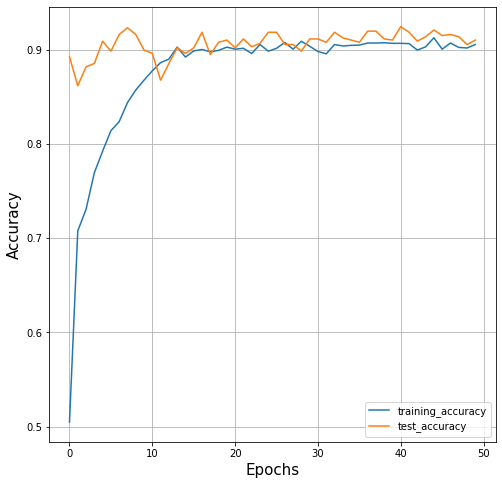

In [12]:
train_mae = history.history['acc']
test_mae = history.history['val_acc']
epochs = range(0,50)
plt.figure(6, figsize=(8,8))
plt.plot(train_mae, label="training_accuracy")
plt.plot(test_mae, label="test_accuracy")
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.grid()

In [13]:
#From above epochs has been been optimized to a value of 15
model.fit( x_train_3D,y_train, epochs = 15 ,batch_size = 50,verbose =2, validation_data =(x_test_3D, y_test))
LSTM_train = model.predict(x_train_3D, verbose = 2)
LSTM_test = model.predict(x_test_3D, verbose = 2)



Train on 3226 samples, validate on 846 samples
Epoch 1/15
 - 0s - loss: 0.0650 - mean_absolute_error: 0.0650 - acc: 0.9157 - val_loss: 0.0902 - val_mean_absolute_error: 0.0902 - val_acc: 0.9137
Epoch 2/15
 - 0s - loss: 0.0668 - mean_absolute_error: 0.0668 - acc: 0.9101 - val_loss: 0.0782 - val_mean_absolute_error: 0.0782 - val_acc: 0.9102
Epoch 3/15
 - 0s - loss: 0.0665 - mean_absolute_error: 0.0665 - acc: 0.9120 - val_loss: 0.0739 - val_mean_absolute_error: 0.0739 - val_acc: 0.9149
Epoch 4/15
 - 0s - loss: 0.0647 - mean_absolute_error: 0.0647 - acc: 0.9076 - val_loss: 0.0833 - val_mean_absolute_error: 0.0833 - val_acc: 0.9113
Epoch 5/15
 - 0s - loss: 0.0641 - mean_absolute_error: 0.0641 - acc: 0.9101 - val_loss: 0.0865 - val_mean_absolute_error: 0.0865 - val_acc: 0.9243
Epoch 6/15
 - 0s - loss: 0.0615 - mean_absolute_error: 0.0615 - acc: 0.9141 - val_loss: 0.0778 - val_mean_absolute_error: 0.0778 - val_acc: 0.9220
Epoch 7/15
 - 0s - loss: 0.0622 - mean_absolute_error: 0.0622 - acc: 0.

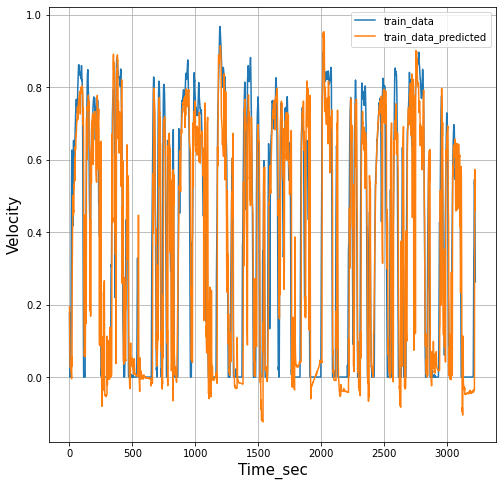

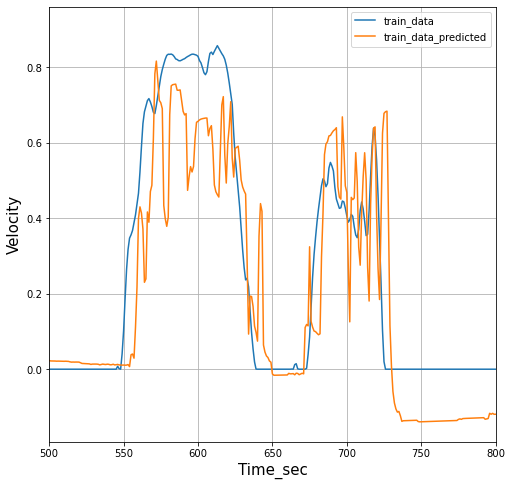

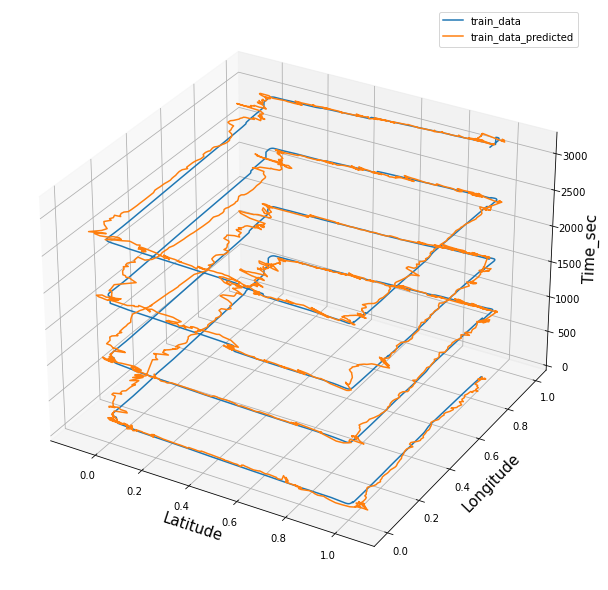

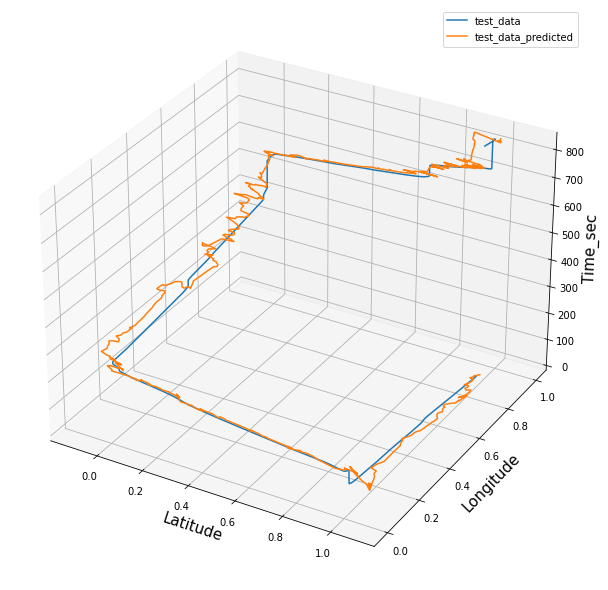

In [14]:
plt.figure(7, figsize=(8,8))
plt.plot(y_train[:,0], label="train_data")
plt.plot(LSTM_train[:,0], label="train_data_predicted" )
plt.xlabel('Time_sec', fontsize = 15)
plt.ylabel('Velocity', fontsize = 15)
plt.legend()
plt.grid()

plt.figure(8, figsize=(8,8))
plt.plot(y_test[:,0], label="train_data")
plt.plot(LSTM_test[:,0], label="train_data_predicted" )
plt.xlabel('Time_sec', fontsize = 15)
plt.ylabel('Velocity', fontsize = 15)
plt.xlim(500,800)
plt.legend()
plt.grid()



fig = plt.figure(9, figsize=(8,8))
steps = list(range(0,3226))
ax = Axes3D(fig)
ax.plot3D(y_train[:,1],y_train[:,2], steps, label="train_data")
ax.plot3D(LSTM_train[:,1], LSTM_train[:,2], steps ,label="train_data_predicted")
ax.set_xlabel('Latitude', fontsize = 15)
ax.set_ylabel('Longitude', fontsize = 15)
ax.set_zlabel("Time_sec", fontsize = 15)
plt.legend()
plt.grid()


fig = plt.figure(10, figsize=(8,8))
steps = list(range(0,846))
ax = Axes3D(fig)
ax.plot3D(y_test[:,1],y_test[:,2], steps, label="test_data")
ax.plot3D(LSTM_test[:,1], LSTM_test[:,2], steps ,label="test_data_predicted")
ax.set_xlabel('Latitude', fontsize = 15)
ax.set_ylabel('Longitude', fontsize = 15)
ax.set_zlabel("Time_sec", fontsize = 15)
plt.legend()
plt.grid()

# Decision Tress

In [15]:
tree_train_MAE= []
tree_test_MAE = []

from sklearn import tree
# For loop to go over different sample split scenarios
for i in range (0,10):
    tree_regressor = tree.DecisionTreeRegressor(min_samples_split=samples_split[i], random_state=2)
    tree_regressor.fit(x_train, y_train)
    tree_predict_train = tree_regressor.predict(x_train)
    tree_predict_test = tree_regressor.predict(x_test)
    tree_train_MAE.append(metrics.mean_absolute_error(y_train[:,0], tree_predict_train[:,0]))
    tree_test_MAE.append(metrics.mean_absolute_error(y_test[:,0], tree_predict_test[:,0]))

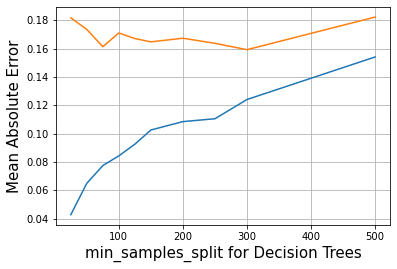

In [16]:
#Comapre the performance of training random forest model for training data set and test data set for predicting velocity
plt.figure(11)
plt.plot(samples_split, tree_train_MAE)
plt.plot(samples_split, tree_test_MAE)
plt.xlabel('min_samples_split for Decision Trees', fontsize = 15)
plt.ylabel('Mean Absolute Error', fontsize = 15)
plt.grid()

In [17]:
# From above figure having a decision trees of min_samples_split of 300 is beneficial.

tree_regressor = tree.DecisionTreeRegressor(min_samples_split=300, random_state=2)
tree_regressor.fit(x_train, y_train)
tree_predict_train = tree_regressor.predict(x_train)
tree_predict_test = tree_regressor.predict(x_test)
print("Mean Absolute Error for training data set:", metrics.mean_absolute_error(y_train[:,0], tree_predict_train[:,0]))
print("Mean Absolute Error for test data set:", metrics.mean_absolute_error(y_test[:,0], tree_predict_test[:,0]))

Mean Absolute Error for training data set: 0.12404642731542122
Mean Absolute Error for test data set: 0.15916839172971117


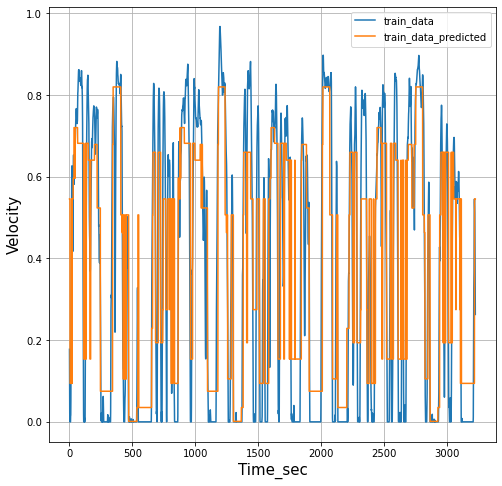

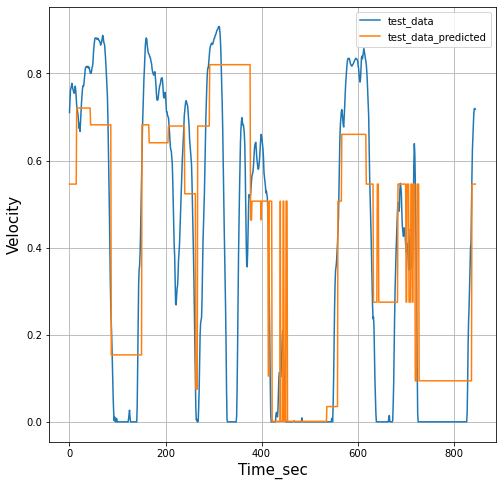

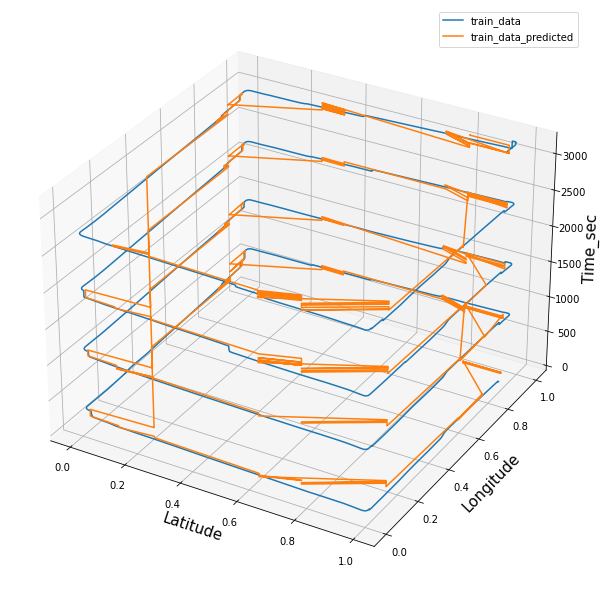

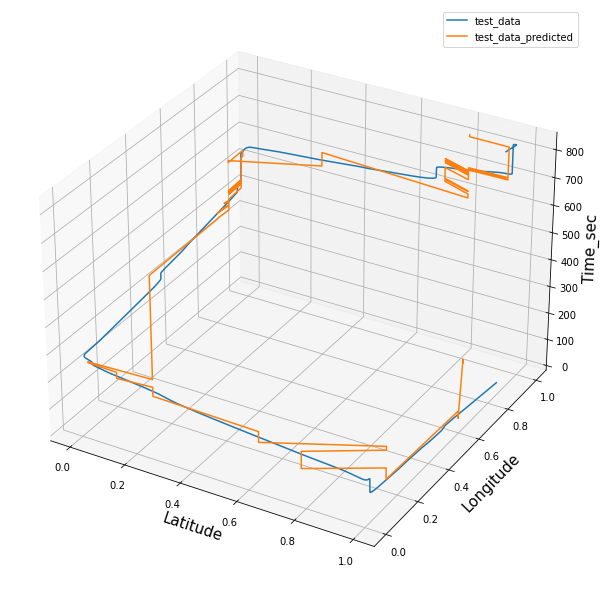

In [18]:
plt.figure(12, figsize=(8,8))
plt.plot(y_train[:,0], label="train_data")
plt.plot(tree_predict_train[:,0], label="train_data_predicted" )
plt.xlabel('Time_sec', fontsize = 15)
plt.ylabel('Velocity', fontsize = 15)
plt.legend()
plt.grid()

plt.figure(13, figsize=(8,8))
plt.plot(y_test[:,0], label="test_data")
plt.plot(tree_predict_test[:,0], label="test_data_predicted")
plt.xlabel('Time_sec', fontsize = 15)
plt.ylabel('Velocity', fontsize = 15)
plt.legend()
plt.grid()

fig = plt.figure(14, figsize=(8,8))
steps = list(range(0,3226))
ax = Axes3D(fig)
ax.plot3D(y_train[:,1],y_train[:,2], steps, label="train_data")
ax.plot3D(tree_predict_train[:,1], tree_predict_train[:,2], steps ,label="train_data_predicted")
ax.set_xlabel('Latitude', fontsize = 15)
ax.set_ylabel('Longitude', fontsize = 15)
ax.set_zlabel("Time_sec", fontsize = 15)
plt.legend()
plt.grid()


fig = plt.figure(15, figsize=(8,8))
steps = list(range(0,846))
ax = Axes3D(fig)
ax.plot3D(y_test[:,1],y_test[:,2], steps, label="test_data")
ax.plot3D(tree_predict_test[:,1], tree_predict_test[:,2], steps ,label="test_data_predicted")
ax.set_xlabel('Latitude', fontsize = 15)
ax.set_ylabel('Longitude', fontsize = 15)
ax.set_zlabel("Time_sec", fontsize = 15)
plt.legend()
plt.grid()


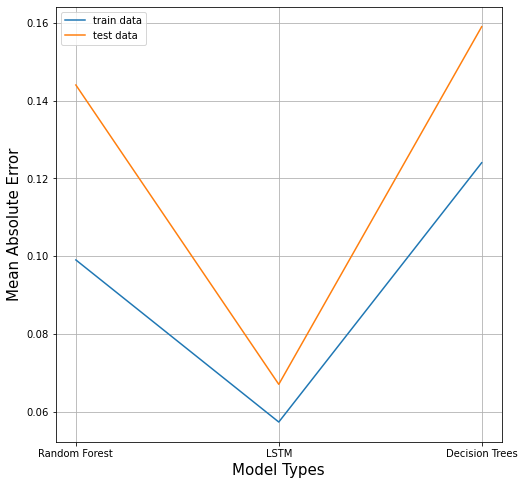

In [19]:
ModelTypes = np.array(['Random Forest', 'LSTM', 'Decision Trees'])
Model_train_MAE_score = np.array([0.099, 0.0573, 0.124 ])
Model_test_MAE_score = np.array([0.144, 0.0670, 0.159 ])

plt.figure(16, figsize=(8,8))
plt.plot(ModelTypes, Model_train_MAE_score, label="train data")
plt.plot(ModelTypes,Model_test_MAE_score, label="test data")
plt.xlabel('Model Types', fontsize = 15)
plt.ylabel('Mean Absolute Error', fontsize = 15)
plt.legend()
plt.grid()